In [5]:
# Cell 1: Import Additional Libraries for LSTM and Metrics
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# The fix is here: direct import from keras within tensorflow
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

print("All necessary libraries for LSTM model development imported.")

# Load the preprocessed data from the previous step
# Ensure this file 'preprocessed_reservoir_data.csv' is in the same directory as your notebook
df = pd.read_csv('preprocessed_reservoir_data.csv', index_col='Date', parse_dates=True)

print("\nData loaded successfully for Step 2. Head:")
print(df.head())
print(f"Total data points: {len(df)}")

All necessary libraries for LSTM model development imported.

Data loaded successfully for Step 2. Head:
            Inflow_ML  Outflow_ML  Reservoir_Level_ML  Rainfall_mm  \
Date                                                                 
2005-01-01  67.254222   49.431606         7000.000000     2.782524   
2005-01-02  81.790101   66.146237         7032.358496     6.242124   
2005-01-03  43.774069   60.406280         7009.986328     1.652324   
2005-01-04  32.664824   57.416624         6982.244871     3.675466   
2005-01-05  57.274710   65.154349         6982.102957     0.000000   

            Temperature_C  Humidity_percent  Demand_ML  DayOfYear  DayOfWeek  \
Date                                                                           
2005-01-01      18.845135         56.487946  50.000000          1          5   
2005-01-02      17.995684         68.138401  63.308641          2          6   
2005-01-03      14.087524         51.565687  57.953183          3          0   
2005

In [6]:
# Cell 2: Data Generation Function (Synthetic Data)

def generate_synthetic_reservoir_data(start_date, end_date, seed=42):
    np.random.seed(seed) # For reproducibility of random data
    dates = pd.date_range(start=start_date, end=end_date, freq='D') # Generate daily dates
    num_days = len(dates)

    # Base reservoir capacity (e.g., 10,000 ML - Million Liters)
    base_capacity = 10000

    # Simulate Inflow: Higher in monsoon season (June-Sept), lower otherwise
    inflow = np.zeros(num_days)
    rainfall = np.zeros(num_days)
    temperature = np.zeros(num_days)
    humidity = np.zeros(num_days)

    for i, date in enumerate(dates):
        # Inflow and Rainfall seasonality
        if 6 <= date.month <= 9:  # June to September (monsoon season in many parts of India)
            inflow[i] = np.random.normal(loc=150, scale=40) + np.random.rand() * 50
            rainfall[i] = np.random.normal(loc=20, scale=15) + np.random.rand() * 10
        else:
            inflow[i] = np.random.normal(loc=50, scale=20) + np.random.rand() * 10
            rainfall[i] = np.random.normal(loc=2, scale=3) + np.random.rand() * 2

        # Ensure non-negative values
        inflow[i] = max(0, inflow[i])
        rainfall[i] = max(0, rainfall[i])

        # Temperature: Higher in summer, lower in winter (sinusoidal pattern + noise)
        temp_cycle = 25 + 10 * np.sin(2 * np.pi * (date.dayofyear - 150) / 365) # Peak approx mid-June
        temperature[i] = np.random.normal(loc=temp_cycle, scale=3)

        # Humidity: Higher in monsoon, lower in dry
        if 6 <= date.month <= 9:
            humidity[i] = np.random.normal(loc=80, scale=10)
        else:
            humidity[i] = np.random.normal(loc=60, scale=15)
        humidity[i] = np.clip(humidity[i], 30, 100) # Clip values to a realistic range

    # Simulate Water Demand: Generally higher in summer, lower in winter
    demand_base = 80 # Base daily demand
    demand = demand_base + 30 * np.sin(2 * np.pi * (dates.dayofyear - 150) / 365) + np.random.normal(0, 10, num_days)
    demand = np.maximum(50, demand) # Ensure minimum demand

    # Simulate reservoir level and outflow based on a simple mass balance
    reservoir_level = np.zeros(num_days)
    outflow = np.zeros(num_days)
    initial_level = base_capacity * 0.7 # Start at 70% capacity

    reservoir_level[0] = initial_level

    for i in range(1, num_days):
        # Historical outflow attempts to meet demand with some fluctuation
        attempted_outflow = demand[i-1] + np.random.uniform(-5, 5)
        # Outflow is also limited by available water (prev_level + current_inflow)
        outflow[i-1] = min(attempted_outflow, reservoir_level[i-1] + inflow[i] - (base_capacity * 0.05)) # Leave some buffer
        outflow[i-1] = max(0, outflow[i-1]) # Ensure non-negative outflow

        # Calculate next reservoir level
        reservoir_level[i] = reservoir_level[i-1] + inflow[i] - outflow[i-1]

        # Prevent reservoir from going below 0 or above base_capacity (simulate overflow/underflow)
        reservoir_level[i] = np.clip(reservoir_level[i], 0, base_capacity)


    # Create a Pandas DataFrame
    data = pd.DataFrame({
        'Date': dates,
        'Inflow_ML': inflow,
        'Outflow_ML': outflow,
        'Reservoir_Level_ML': reservoir_level,
        'Rainfall_mm': rainfall,
        'Temperature_C': temperature,
        'Humidity_percent': humidity,
        'Demand_ML': demand
    })
    data.set_index('Date', inplace=True) # Set 'Date' column as the DataFrame index
    return data

print("Data generation function defined.")

Data generation function defined.


In [7]:
# Cell 3: Generate Data and Initial Inspection

start_date = '2005-01-01'
end_date = '2024-12-31' # Approximately 20 years
df = generate_synthetic_reservoir_data(start_date, end_date)

print("--- Synthetic Data Head (First 5 Rows) ---")
print(df.head())

print("\n--- Synthetic Data Info (Data Types & Missing Values) ---")
df.info()

print("\n--- Synthetic Data Description (Statistical Summary) ---")
print(df.describe())

--- Synthetic Data Head (First 5 Rows) ---
            Inflow_ML  Outflow_ML  Reservoir_Level_ML  Rainfall_mm  \
Date                                                                 
2005-01-01  67.254222   49.431606         7000.000000     2.782524   
2005-01-02  81.790101   66.146237         7032.358496     6.242124   
2005-01-03  43.774069   60.406280         7009.986328     1.652324   
2005-01-04  32.664824   57.416624         6982.244871     3.675466   
2005-01-05  57.274710   65.154349         6982.102957     0.000000   

            Temperature_C  Humidity_percent  Demand_ML  
Date                                                    
2005-01-01      18.845135         56.487946  50.000000  
2005-01-02      17.995684         68.138401  63.308641  
2005-01-03      14.087524         51.565687  57.953183  
2005-01-04      23.519094         56.613355  55.962202  
2005-01-05      15.530779         65.635470  60.229352  

--- Synthetic Data Info (Data Types & Missing Values) ---
<class '

In [8]:
# Cell 4: Data Preprocessing - Adding Time-based Features

df['DayOfYear'] = df.index.dayofyear # Day number within the year (1-366)
df['DayOfWeek'] = df.index.dayofweek # Day of the week (0=Monday, 6=Sunday)
df['Month'] = df.index.month       # Month number (1-12)
df['Year'] = df.index.year         # Year

print("\n--- Data Head after Adding Time-based Features ---")
print(df.head())

print(f"\nNew columns added: DayOfYear, DayOfWeek, Month, Year. Total columns: {df.shape[1]}")


--- Data Head after Adding Time-based Features ---
            Inflow_ML  Outflow_ML  Reservoir_Level_ML  Rainfall_mm  \
Date                                                                 
2005-01-01  67.254222   49.431606         7000.000000     2.782524   
2005-01-02  81.790101   66.146237         7032.358496     6.242124   
2005-01-03  43.774069   60.406280         7009.986328     1.652324   
2005-01-04  32.664824   57.416624         6982.244871     3.675466   
2005-01-05  57.274710   65.154349         6982.102957     0.000000   

            Temperature_C  Humidity_percent  Demand_ML  DayOfYear  DayOfWeek  \
Date                                                                           
2005-01-01      18.845135         56.487946  50.000000          1          5   
2005-01-02      17.995684         68.138401  63.308641          2          6   
2005-01-03      14.087524         51.565687  57.953183          3          0   
2005-01-04      23.519094         56.613355  55.962202   

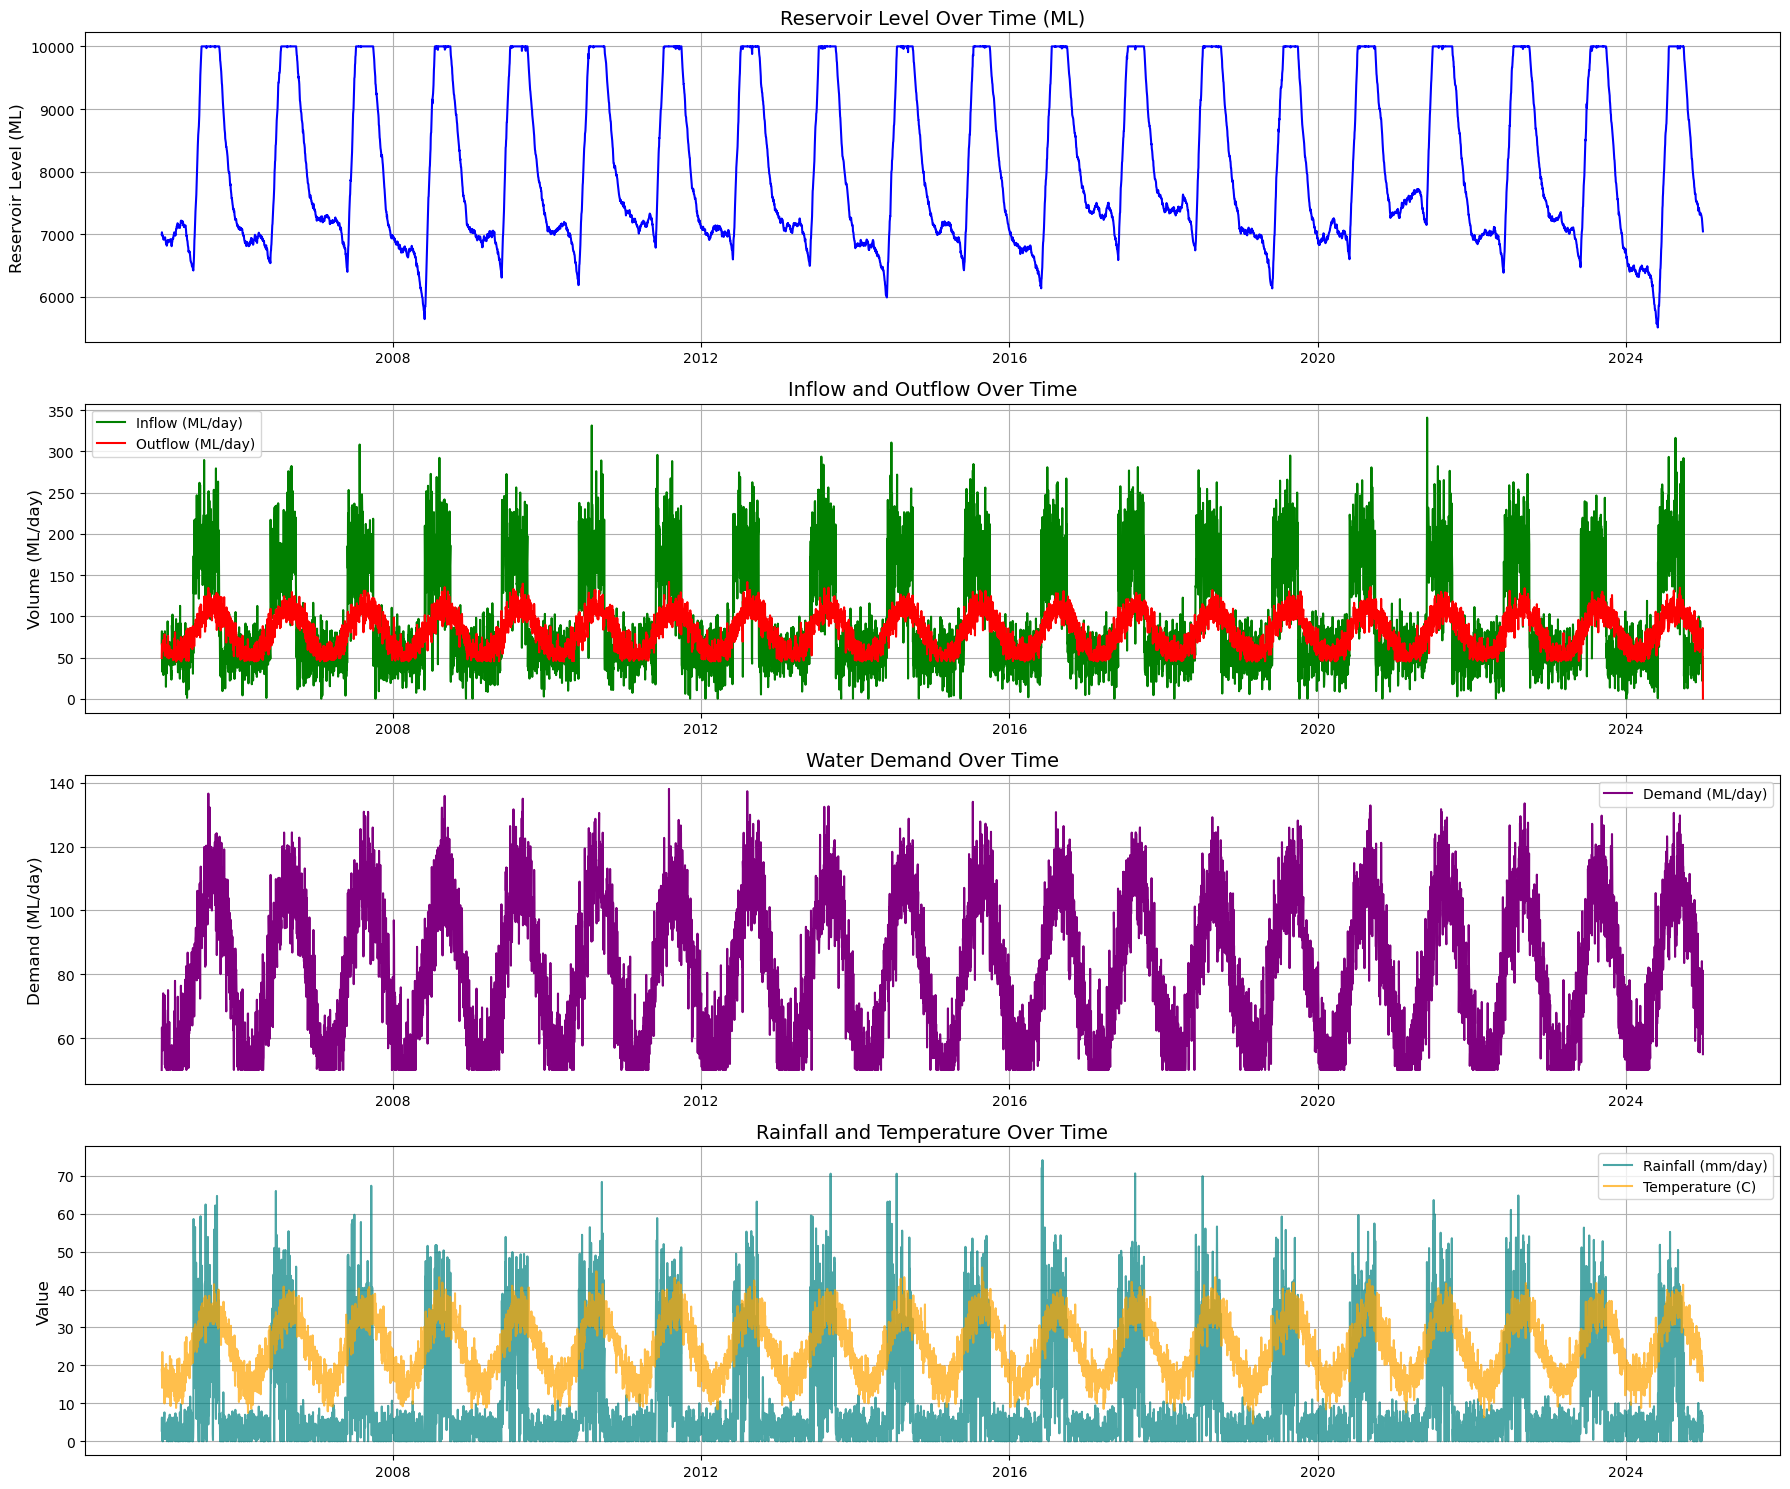


Visualizations displayed. Analyze patterns and trends.


In [9]:
# Cell 5: Data Visualization

plt.figure(figsize=(18, 15)) # Set the figure size for better readability

# Plot 1: Reservoir Level Over Time
plt.subplot(4, 1, 1) # 4 rows, 1 column, 1st plot
plt.plot(df.index, df['Reservoir_Level_ML'], color='blue')
plt.title('Reservoir Level Over Time (ML)', fontsize=14)
plt.ylabel('Reservoir Level (ML)', fontsize=12)
plt.grid(True) # Add a grid for easier reading

# Plot 2: Inflow and Outflow Over Time
plt.subplot(4, 1, 2) # 4 rows, 1 column, 2nd plot
plt.plot(df.index, df['Inflow_ML'], label='Inflow (ML/day)', color='green')
plt.plot(df.index, df['Outflow_ML'], label='Outflow (ML/day)', color='red')
plt.title('Inflow and Outflow Over Time', fontsize=14)
plt.ylabel('Volume (ML/day)', fontsize=12)
plt.legend()
plt.grid(True)

# Plot 3: Water Demand Over Time
plt.subplot(4, 1, 3) # 4 rows, 1 column, 3rd plot
plt.plot(df.index, df['Demand_ML'], label='Demand (ML/day)', color='purple')
plt.title('Water Demand Over Time', fontsize=14)
plt.ylabel('Demand (ML/day)', fontsize=12)
plt.legend()
plt.grid(True)

# Plot 4: Weather Data (Rainfall & Temperature)
plt.subplot(4, 1, 4) # 4 rows, 1 column, 4th plot
plt.plot(df.index, df['Rainfall_mm'], label='Rainfall (mm/day)', color='teal', alpha=0.7)
plt.plot(df.index, df['Temperature_C'], label='Temperature (C)', color='orange', alpha=0.7)
plt.title('Rainfall and Temperature Over Time', fontsize=14)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plots

print("\nVisualizations displayed. Analyze patterns and trends.")

In [10]:
# Cell 6: Save Preprocessed Data

output_filename = 'preprocessed_reservoir_data.csv'
df.to_csv(output_filename)

print(f"\nPreprocessed data saved to '{output_filename}'")
print("Step 1 (Data Gathering and Basic Preprocessing) complete!")


Preprocessed data saved to 'preprocessed_reservoir_data.csv'
Step 1 (Data Gathering and Basic Preprocessing) complete!


In [11]:
# Cell 2: Define Target and Features & Time-Based Data Split

# Define our primary target variable
target_column = 'Reservoir_Level_ML' # Our goal is to predict reservoir level

# Define features: all columns except the target and 'Year' (as 'Year' itself isn't a repeating pattern for LSTM)
features = [col for col in df.columns if col != target_column and col != 'Year']

# Combine features and target into the final dataset for scaling and sequence creation
data_for_model = df[features + [target_column]] # Ensure target is the last column for simplicity in `create_sequences`

print(f"Features chosen for LSTM: {features}")
print(f"Target chosen: {target_column}")
print(f"Shape of data_for_model: {data_for_model.shape}")

# Time-Based Data Split
# We'll use 80% of the data for training and 20% for testing.
train_size = int(len(data_for_model) * 0.8)
train_data_raw = data_for_model.iloc[:train_size]
test_data_raw = data_for_model.iloc[train_size:]

print(f"\nTraining data covers: {train_data_raw.index.min()} to {train_data_raw.index.max()}")
print(f"Testing data covers: {test_data_raw.index.min()} to {test_data_raw.index.max()}")
print(f"Train data shape (raw): {train_data_raw.shape}")
print(f"Test data shape (raw): {test_data_raw.shape}")

Features chosen for LSTM: ['Inflow_ML', 'Outflow_ML', 'Rainfall_mm', 'Temperature_C', 'Humidity_percent', 'Demand_ML', 'DayOfYear', 'DayOfWeek', 'Month']
Target chosen: Reservoir_Level_ML
Shape of data_for_model: (7305, 10)

Training data covers: 2005-01-01 00:00:00 to 2020-12-31 00:00:00
Testing data covers: 2021-01-01 00:00:00 to 2024-12-31 00:00:00
Train data shape (raw): (5844, 10)
Test data shape (raw): (1461, 10)


In [12]:
# Cell 3: Normalization (Correctly Applied for Time Series)

# Initialize the MinMaxScaler
# We will scale all columns in `data_for_model`
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler ONLY on the training data's values
# This learns the min/max values from the training set.
scaled_train_data = scaler.fit_transform(train_data_raw)

# Transform BOTH training and test data using the *same* fitted scaler
# The test data is transformed using the min/max values learned from the training data.
scaled_test_data = scaler.transform(test_data_raw)

print(f"Shape of scaled_train_data: {scaled_train_data.shape}")
print(f"Shape of scaled_test_data: {scaled_test_data.shape}")

# Optional: Convert back to DataFrame for easier inspection, though not strictly needed for sequence creation
# Note: Column names are lost in numpy array after scaling, so we put them back
scaled_train_df = pd.DataFrame(scaled_train_data, columns=data_for_model.columns, index=train_data_raw.index)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=data_for_model.columns, index=test_data_raw.index)

print("\nSample of Scaled Training Data (first 5 rows):")
print(scaled_train_df.head())

Shape of scaled_train_data: (5844, 10)
Shape of scaled_test_data: (1461, 10)

Sample of Scaled Training Data (first 5 rows):
            Inflow_ML  Outflow_ML  Rainfall_mm  Temperature_C  \
Date                                                            
2005-01-01   0.202911    0.045682     0.037545       0.345023   
2005-01-02   0.246767    0.218498     0.084225       0.324388   
2005-01-03   0.132070    0.159151     0.022295       0.229449   
2005-01-04   0.098552    0.128241     0.049593       0.458565   
2005-01-05   0.172802    0.208243     0.000000       0.264509   

            Humidity_percent  Demand_ML  DayOfYear  DayOfWeek  Month  \
Date                                                                   
2005-01-01          0.378399   0.000000   0.000000   0.833333    0.0   
2005-01-02          0.544834   0.151091   0.002740   1.000000    0.0   
2005-01-03          0.308081   0.090291   0.005479   0.000000    0.0   
2005-01-04          0.380191   0.067688   0.008219   0.1666

In [13]:
# Cell 4: Create Sequences for LSTM Input

def create_sequences(data_array, look_back, forecast_horizon, target_col_name, all_column_names):
    X, y = [], []
    # Find the index of the target column in the original `all_column_names` list
    target_idx = all_column_names.get_loc(target_col_name)

    # Iterate through the data to create sequences
    # The loop stops early enough so that there's always enough data for a full look_back and forecast_horizon
    for i in range(len(data_array) - look_back - forecast_horizon + 1):
        # Input sequence (X): 'look_back' days of all features
        seq_x = data_array[i:(i + look_back), :]
        X.append(seq_x)

        # Output sequence (y): 'forecast_horizon' days of the target variable
        seq_y = data_array[(i + look_back):(i + look_back + forecast_horizon), target_idx]
        y.append(seq_y)

    return np.array(X), np.array(y)

# Define Hyperparameters for Sequence Creation
look_back = 30    # Number of past days to use as input for prediction
forecast_horizon = 7 # Number of future days to predict (e.g., predict reservoir level for next 7 days)

# Get the list of column names to pass to the function (needed to find target index)
all_column_names_for_model = data_for_model.columns

# Create sequences for training and testing data
X_train, y_train = create_sequences(scaled_train_data, look_back, forecast_horizon, target_column, all_column_names_for_model)
X_test, y_test = create_sequences(scaled_test_data, look_back, forecast_horizon, target_column, all_column_names_for_model)

print(f"\nShape of X_train: {X_train.shape} (samples, look_back_days, features)")
print(f"Shape of y_train: {y_train.shape} (samples, forecast_horizon_days)")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (5808, 30, 10) (samples, look_back_days, features)
Shape of y_train: (5808, 7) (samples, forecast_horizon_days)
Shape of X_test: (1425, 30, 10)
Shape of y_test: (1425, 7)


In [14]:
# Cell 5: Build the LSTM Model Architecture

# Get the number of features from our X_train shape
n_features = X_train.shape[2]

model = Sequential() # Initialize a sequential model (a linear stack of layers)

# First LSTM Layer:
# units=100: Number of LSTM units (neurons) in this layer.
# return_sequences=True: This is crucial! It means this LSTM layer will output a sequence
#                       for the *next* LSTM layer. If it were the last LSTM layer, it would be False.
# input_shape=(look_back, n_features): Defines the expected shape of a single input sample.
model.add(LSTM(units=100, return_sequences=True, input_shape=(look_back, n_features)))
model.add(Dropout(0.3)) # Innovative Feature: Dropout layer to prevent overfitting.
                        # It randomly sets a fraction of input units to 0 at each update during training.

# Second LSTM Layer:
# units=100: Another 100 LSTM units.
# return_sequences=False: This is the last LSTM layer, so we want it to output a single vector
#                        representing the learned features from the entire sequence, not another sequence.
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3)) # Another Dropout layer.

# Output Dense Layer:
# units=forecast_horizon: A Dense (fully connected) layer that outputs 'forecast_horizon' values.
#                         Since we are predicting 7 days of Reservoir Level, this will be 7 outputs.
model.add(Dense(units=forecast_horizon))

# Compile the model: Configure the model for training
model.compile(optimizer='adam', # Adam is a popular and efficient optimizer
              loss='mse')      # Mean Squared Error (MSE) is a common loss function for regression tasks

# Print the model summary to see its architecture
model.summary()

C:\Users\Swayam\anaconda3\envs\reservoir_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 100)             │          44,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,507 (490.26 KB)

 Trainable params: 125,507 (490.26 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Cell 6: Train the LSTM Model

# Innovative Feature: Early Stopping
# This callback monitors a specified metric (validation loss here) and stops training
# if the metric stops improving for a certain number of epochs (patience).
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (validation loss)
    patience=10,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
    verbose=1                   # Show messages when stopping
)

# Innovative Feature: Model Checkpointing
# This callback saves the model's weights during training, typically only saving the best version.
model_checkpoint = ModelCheckpoint(
    'best_reservoir_lstm_model.keras', # File path to save the model. '.keras' is the recommended modern format.
    monitor='val_loss',
    save_best_only=True,        # Only save the model when validation loss improves
    mode='min',                 # 'min' means we want to minimize the monitored metric (loss)
    verbose=1                   # Show messages when saving
)

# Train the model
history = model.fit(
    X_train, y_train,         # Training data and targets
    epochs=100,               # Maximum number of training iterations. Early stopping will likely stop it sooner.
    batch_size=32,            # Number of samples per gradient update
    validation_split=0.1,     # Use 10% of the training data as a validation set
                              # This data is used to monitor performance during training, but not for weight updates.
    callbacks=[early_stopping, model_checkpoint], # List of callbacks to use
    verbose=1                 # Show training progress
)

print("\nLSTM Model Training Complete.")

Epoch 1/100
163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0544
Epoch 1: val_loss improved from inf to 0.00125, saving model to best_reservoir_lstm_model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - loss: 0.0540 - val_loss: 0.0012
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0085
Epoch 2: val_loss did not improve from 0.00125
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - loss: 0.0085 - val_loss: 0.0019
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0062
Epoch 3: val_loss did not improve from 0.00125
164/164 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 0.0062 - val_loss: 0.0015
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0046
Epoch 4: val_loss improved from 0.00125 to 0.00086, saving model to best_reservoir_lstm_model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - loss: 0.0046 - val_loss: 8.6437e-04
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0042
Epoch 5: val_loss did not improve from 0.00086
164/16

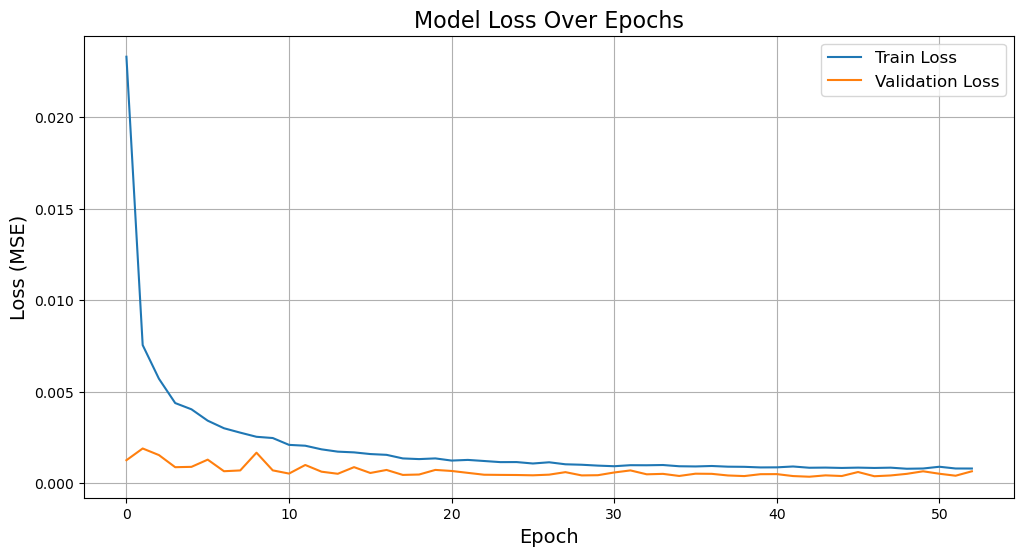


Training loss plot displayed. Look for convergence and signs of overfitting (validation loss increasing).


In [16]:
# Cell 7: Plot Training History

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

print("\nTraining loss plot displayed. Look for convergence and signs of overfitting (validation loss increasing).")

Best model loaded successfully.
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
Shape of scaled predictions: (1425, 7)
Shape of actual_unscaled_y_test: (1425, 7)
Shape of y_pred_unscaled: (1425, 7)

Model Evaluation on Test Data for 'Reservoir_Level_ML':
Mean Squared Error (MSE): 5678.94
Root Mean Squared Error (RMSE): 75.36 ML
Mean Absolute Error (MAE): 50.43 ML
R-squared (R2): 0.9968


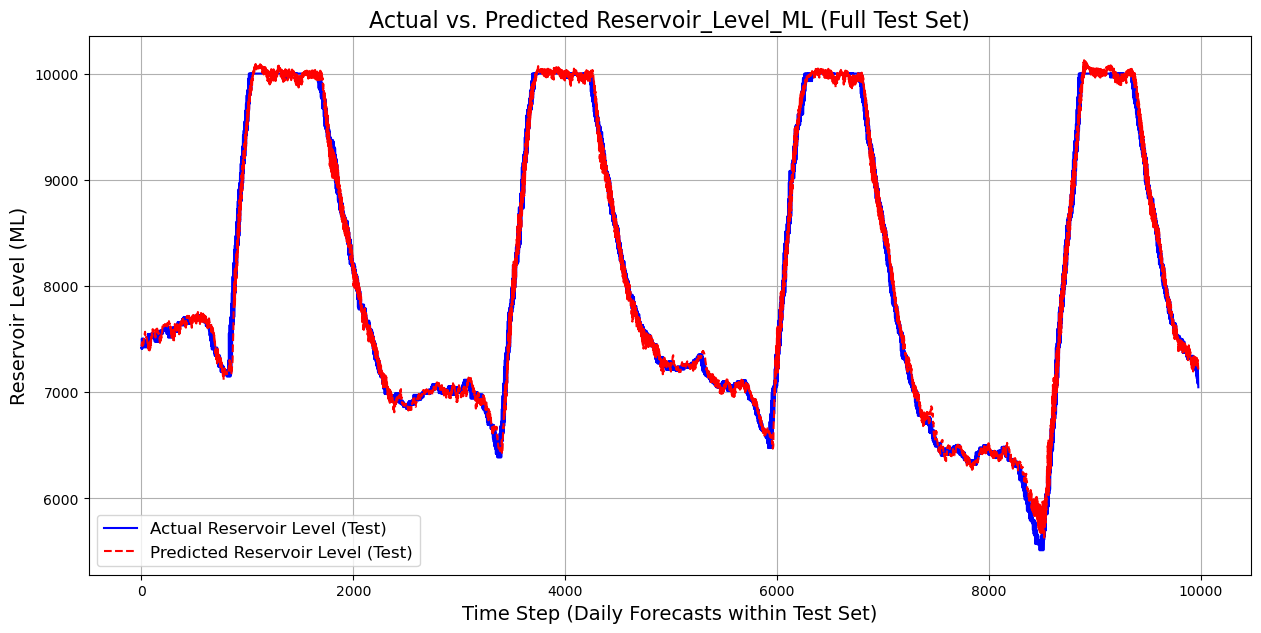


Step 2 (LSTM Model Development) complete!


In [23]:
# Cell 8: Evaluate the Model on Test Data

# Load the best model weights saved by ModelCheckpoint
best_model = tf.keras.models.load_model('best_reservoir_lstm_model.keras')
print("Best model loaded successfully.")

# Make predictions on the scaled test set
y_pred_scaled = best_model.predict(X_test)
print(f"Shape of scaled predictions: {y_pred_scaled.shape}")

# --- Innovative Feature: Inverse Transform Predictions and Actuals ---
# This part is a bit tricky because our scaler was fitted on ALL features.
# To inverse transform only the target (Reservoir_Level_ML), we need to create
# dummy arrays with the same number of features that the scaler expects.

# 1. Prepare dummy array for y_test (actual values)
# y_test contains scaled target values. We need to create a full feature array to inverse_transform them.
# The original scaled_test_data has all features. We need to align y_test with corresponding original rows.
# Since `y_test` are the actual *future* values, we need to extract them from `test_data_raw`'s values.

actual_unscaled_y_test = []
# Loop through the raw test data similar to how sequences were created for `y_test`
# We need to get the corresponding unscaled values for the target column for each sequence in y_test
# The original `y_test` was created from `scaled_test_data`.
# We need to get the actual unscaled values from `test_data_raw` that correspond to `y_test`.
# Let's adjust this part to align correctly.

# The `y_test` array's first dimension corresponds to the number of samples in X_test.
# Each sample in `y_test` has `forecast_horizon` values.
# The index in `test_data_raw` corresponding to `y_test[i][0]` is `look_back + i`.

# Get the index of the target column in the original `data_for_model` DataFrame
target_col_idx_in_raw_data = data_for_model.columns.get_loc(target_column)

# Reconstruct `actual_unscaled_y_test` by slicing `test_data_raw` directly
# based on the indices implied by `X_test` and `y_test` creation.
# The `y_test` samples correspond to `test_data_raw` starting from `look_back` index.
# The number of actual test sequences is `len(test_data_raw) - look_back - forecast_horizon + 1`.
# So, `actual_unscaled_y_test` will correspond to the last `len(y_test)` rows of `test_data_raw`
# shifted by `look_back`.

# This is the correct way to get the unscaled y_test data points that correspond to our X_test and y_test samples.
# The `y_test` samples begin at index `look_back` within `scaled_test_data`.
# So, `actual_unscaled_y_test` should start from `test_data_raw.iloc[look_back:]` and be shaped correctly.

# Let's rebuild the actual_unscaled_y_test carefully
actual_unscaled_y_test = []
for i in range(len(test_data_raw) - look_back - forecast_horizon + 1):
    # Get the actual unscaled target values for the forecast horizon
    actual_sequence = test_data_raw.iloc[i + look_back : i + look_back + forecast_horizon][target_column].values
    actual_unscaled_y_test.append(actual_sequence)

actual_unscaled_y_test = np.array(actual_unscaled_y_test)
print(f"Shape of actual_unscaled_y_test: {actual_unscaled_y_test.shape}")


# 2. Inverse transform y_pred_scaled
# This part is correct from previous version, creating dummy array to inverse transform specific column
y_pred_unscaled = []
for i in range(y_pred_scaled.shape[0]):
    temp_scaled_row = np.zeros((forecast_horizon, data_for_model.shape[1]))
    temp_scaled_row[:, target_col_idx_in_raw_data] = y_pred_scaled[i, :]
    inverse_transformed_temp = scaler.inverse_transform(temp_scaled_row)
    y_pred_unscaled.append(inverse_transformed_temp[:, target_col_idx_in_raw_data])

y_pred_unscaled = np.array(y_pred_unscaled)
print(f"Shape of y_pred_unscaled: {y_pred_unscaled.shape}")


# --- Calculate Evaluation Metrics ---
# We flatten the arrays to calculate metrics across all predictions
y_test_flat = actual_unscaled_y_test.flatten()
y_pred_flat = y_pred_unscaled.flatten()

mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse) # Root Mean Squared Error
mae = mean_absolute_error(y_test_flat, y_pred_flat)
r2 = r2_score(y_test_flat, y_pred_flat)

print(f"\nModel Evaluation on Test Data for '{target_column}':")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} ML")
print(f"Mean Absolute Error (MAE): {mae:.2f} ML")
print(f"R-squared (R2): {r2:.4f}")


# --- Innovative Feature: Visualize Predictions vs. Actuals ---
# This is crucial for understanding model performance visually.
# We'll plot a subset of the test data for clarity.

plt.figure(figsize=(15, 7))
# We can't plot by date directly here because `y_test_flat` is not indexed by date.
# We'll plot by time step.
plot_start_step = len(y_test_flat) - (365 * forecast_horizon) if len(y_test_flat) > (365 * forecast_horizon) else 0 # Plot last year of daily forecasts
plot_start_step = 0 # For now, let's plot from beginning to see general trend, or select a smaller chunk if too dense

plt.plot(actual_unscaled_y_test.flatten()[plot_start_step:], label='Actual Reservoir Level (Test)', color='blue')
plt.plot(y_pred_unscaled.flatten()[plot_start_step:], label='Predicted Reservoir Level (Test)', color='red', linestyle='--')

plt.title(f'Actual vs. Predicted {target_column} (Full Test Set)', fontsize=16)
plt.xlabel('Time Step (Daily Forecasts within Test Set)', fontsize=14)
plt.ylabel('Reservoir Level (ML)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

print("\nStep 2 (LSTM Model Development) complete!")

In [18]:
# Cell 1: Import Additional Libraries for Genetic Algorithm
import pandas as pd
import numpy as np
import tensorflow as tf # To load the trained LSTM model
from sklearn.preprocessing import MinMaxScaler # To inverse transform predictions
import matplotlib.pyplot as plt # For visualization
import random # For genetic algorithm operations
import copy # For deep copying individuals in GA

print("Genetic Algorithm libraries imported.")

# Load the preprocessed data (same as Step 2, to get raw data for inverse scaling)
df_original = pd.read_csv('preprocessed_reservoir_data.csv', index_col='Date', parse_dates=True)
# We'll need the original train_data_raw, test_data_raw, and scaler from Step 2
# For simplicity, we'll re-run some initial setup if this is a fresh run
# (If you ran the notebook top-to-bottom, these variables should still be in memory)

# --- Re-define parameters and load scaler/model if running this cell alone ---
# This ensures consistency if you run this section independently.
# In a continuous notebook run, these variables would already exist from Step 2.

target_column = 'Reservoir_Level_ML'
features = [col for col in df_original.columns if col != target_column and col != 'Year']
data_for_model = df_original[features + [target_column]]

train_size = int(len(data_for_model) * 0.8)
train_data_raw = data_for_model.iloc[:train_size]
test_data_raw = data_for_model.iloc[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data_raw)
scaled_test_data = scaler.transform(test_data_raw) # Needed for getting test_data_raw min/max for inverse_transform

# Define look_back and forecast_horizon (must match what was used for LSTM training)
look_back = 30
forecast_horizon = 7

# Load the trained LSTM model
best_model = tf.keras.models.load_model('best_reservoir_lstm_model.keras')
print("Trained LSTM model loaded successfully.")

# Get target column index for inverse scaling later
target_col_idx_in_raw_data = data_for_model.columns.get_loc(target_column)

# Base capacity for reservoir (from Step 1 data generation, needed for GA fitness)
# Let's re-define it here for clarity or grab it from some global constant if defined
# In a real system, this would be a fixed parameter of the dam.
RESERVOIR_MAX_CAPACITY_ML = 10000 # Matches what was used in generate_synthetic_reservoir_data
MIN_RESERVOIR_LEVEL_ML = 1000 # Define a minimum safe level for reservoir (e.g., 10% of capacity)

Genetic Algorithm libraries imported.
Trained LSTM model loaded successfully.


In [19]:
# Cell 2: Define Genetic Algorithm Components

class Individual:
    def __init__(self, release_schedule):
        # A release_schedule is a list/array of water volumes (ML/day) for the forecast_horizon
        self.release_schedule = np.array(release_schedule, dtype=float)
        self.fitness = 0.0 # Fitness value (higher is better)

def initialize_population(pop_size, forecast_horizon, min_release, max_release):
    # Initializes a population of random release schedules
    population = []
    for _ in range(pop_size):
        # Each 'gene' is a daily release amount within a defined range
        schedule = np.random.uniform(min_release, max_release, forecast_horizon)
        population.append(Individual(schedule))
    return population

def calculate_fitness(individual, current_reservoir_level_ml, forecast_inflow_ml, forecast_demand_ml,
                      scaler_obj, model, look_back_days, all_features_names, target_name, target_idx,
                      max_capacity, min_level):
    """
    Calculates the fitness of a release schedule.
    Fitness is higher for schedules that meet demand, avoid overflow, and conserve water.
    Penalties for overflow and unmet demand.
    """
    simulated_reservoir_levels = [current_reservoir_level_ml] # Start with current level
    total_unmet_demand = 0
    total_overflow = 0
    total_released_water = 0 # To track water conservation

    # Prepare historical data for LSTM prediction (context for the forecast horizon)
    # We need the last `look_back_days` of scaled data to make predictions.
    # We will use the end of the training data as the "current" state for this simulation
    # In a real-time system, this would be the actual past `look_back_days` of real data.

    # For this simulation, let's assume we are forecasting from the beginning of the test set.
    # So, we need the last 'look_back' days from the end of the training data (`scaled_train_data`)
    # and the first 'forecast_horizon' real values for comparing against LSTM.
    # To simplify for the GA, let's assume `current_reservoir_level_ml` is the last actual observed
    # level, and we forecast `forecast_inflow_ml` and `forecast_demand_ml`.

    # We need to simulate the reservoir level day by day over the forecast horizon.
    # The LSTM will then re-predict based on these simulated values.
    # This is a closed-loop simulation: GA proposes release -> simulate reservoir -> LSTM updates prediction.

    # We need historical context for the LSTM
    # For now, let's make a simplified assumption: forecast_inflow and forecast_demand are fixed for the horizon.
    # A more advanced GA would involve calling the LSTM at each step of the simulation.

    # Simplified simulation for fitness calculation
    current_level = current_reservoir_level_ml
    for day in range(forecast_horizon):
        daily_inflow = forecast_inflow_ml[day] # Assumes fixed forecast
        daily_demand = forecast_demand_ml[day] # Assumes fixed forecast
        daily_release = individual.release_schedule[day]

        # Ensure release is within sensible bounds (cannot release more than available, cannot be negative)
        daily_release = np.clip(daily_release, 0, current_level + daily_inflow)

        # Calculate next reservoir level
        next_level = current_level + daily_inflow - daily_release

        # Handle overflow
        if next_level > max_capacity:
            total_overflow += (next_level - max_capacity)
            next_level = max_capacity # Cap at max capacity

        # Handle unmet demand (if release was less than demand)
        # Assuming demand_met = min(daily_release, daily_demand) is not strictly true as daily_release is what GA suggests
        # We need to check if the demand could actually be met by `daily_release`.
        # This is a subtle point: The GA optimizes `daily_release`, not `demand_met`.
        # However, a good release strategy *should* aim to meet demand.
        # So, we penalize if `daily_release` is less than `daily_demand` assuming that if GA suggests it, that's what happens.
        if daily_release < daily_demand:
            total_unmet_demand += (daily_demand - daily_release)

        # Penalize if level drops below minimum safe level
        if next_level < min_level:
            total_unmet_demand += (min_level - next_level) * 2 # Heavier penalty for critical low levels

        total_released_water += daily_release
        current_level = next_level
        simulated_reservoir_levels.append(current_level)

    # Fitness calculation: Maximize water conservation and meeting demand, minimize overflow.
    # We want to minimize penalties (unmet demand, overflow) and potentially maximize water in reservoir at end.
    # Or, minimize water released unless necessary.
    # Let's define fitness as: a high base value - penalty.
    # Lower penalty means higher fitness.

    # Penalties (adjust weights as per problem importance)
    penalty_unmet_demand = total_unmet_demand * 10  # High penalty for not meeting demand
    penalty_overflow = total_overflow * 5          # Penalty for wasting water
    # Penalty for leaving reservoir too empty at the end of horizon? (Encourage conservation, but not critically low)
    # Or reward for being close to optimal level (e.g., 80% capacity)
    # For now, let's focus on penalties.

    # Innovative Feature: Reward for ending near optimal capacity range (e.g., 60-80% capacity)
    final_level = simulated_reservoir_levels[-1]
    optimal_level_target = max_capacity * 0.7 # Aim for 70% capacity at end of horizon
    level_deviation_penalty = abs(final_level - optimal_level_target) * 0.1 # Small penalty for deviation

    total_penalty = penalty_unmet_demand + penalty_overflow + level_deviation_penalty

    # Fitness: We want to *maximize* fitness, so inverse of penalty (or 1 / (1+penalty))
    # Or a base score minus penalties.
    # A simple fitness that rewards meeting demand and avoiding overflow.
    # Max possible reward - total_penalty. Max reward can be arbitrary large, e.g., 1,000,000
    fitness = 1_000_000 - total_penalty
    if fitness < 0: fitness = 1 # Ensure fitness is at least 1, to avoid issues with 0 or negative.

    individual.fitness = fitness
    return fitness


def selection(population, num_parents):
    # Tournament selection: randomly pick a few individuals and select the best among them
    parents = []
    for _ in range(num_parents):
        tournament_size = 5 # Number of individuals in each tournament
        tournament_candidates = random.sample(population, tournament_size)
        fittest_candidate = max(tournament_candidates, key=lambda ind: ind.fitness)
        parents.append(fittest_candidate)
    return parents

def crossover(parent1, parent2):
    # Single-point crossover for release schedules
    if len(parent1.release_schedule) < 2: # Handle very short schedules
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    crossover_point = random.randint(1, len(parent1.release_schedule) - 1)
    child1_schedule = np.concatenate((parent1.release_schedule[:crossover_point],
                                      parent2.release_schedule[crossover_point:]))
    child2_schedule = np.concatenate((parent2.release_schedule[:crossover_point],
                                      parent1.release_schedule[crossover_point:]))
    return Individual(child1_schedule), Individual(child2_schedule)

def mutate(individual, mutation_rate, min_release, max_release, mutation_strength=0.1):
    # Mutate individual release amounts
    for i in range(len(individual.release_schedule)):
        if random.random() < mutation_rate:
            # Add a small random value (positive or negative) to the current release
            change = np.random.normal(0, mutation_strength * (max_release - min_release))
            individual.release_schedule[i] = np.clip(individual.release_schedule[i] + change, min_release, max_release)


print("Genetic Algorithm components (Individual class, functions) defined.")

Genetic Algorithm components (Individual class, functions) defined.


In [24]:
# Cell 3: Implement the Genetic Algorithm Loop

def run_genetic_algorithm(current_level, forecast_inflow, forecast_demand,
                          scaler_obj, model, look_back_days, all_features_names, target_name, target_idx,
                          max_capacity, min_level,
                          pop_size=100, num_generations=100, mutation_rate=0.1, min_release=0, max_release=500):
    """
    Runs the genetic algorithm to find an optimal water release schedule.
    """
    # 1. Initialize Population
    population = initialize_population(pop_size, forecast_horizon, min_release, max_release)

    best_overall_individual = None
    best_overall_fitness = -np.inf # Initialize with negative infinity

    print("\nStarting Genetic Algorithm...")
    for generation in range(num_generations):
        # 2. Evaluate Fitness for all individuals
        for individual in population:
            calculate_fitness(individual, current_level, forecast_inflow, forecast_demand,
                              scaler_obj, model, look_back_days, all_features_names, target_name, target_idx,
                              max_capacity, min_level)

        # Find the best individual in the current generation
        current_best_individual = max(population, key=lambda ind: ind.fitness)

        # Update overall best
        if current_best_individual.fitness > best_overall_fitness:
            best_overall_fitness = current_best_individual.fitness
            best_overall_individual = copy.deepcopy(current_best_individual) # Deep copy to save state

        if (generation + 1) % 10 == 0 or generation == 0:
            print(f"Generation {generation+1}/{num_generations}, Best Fitness: {best_overall_fitness:.2f}, "
                  f"Best Release (first 3 days): {best_overall_individual.release_schedule[:3].round(2)}")

        # 3. Selection: Choose parents for the next generation
        num_parents = pop_size // 2 # Select half the population as parents
        parents = selection(population, num_parents)

        # 4. Create Next Generation
        next_population = []
        next_population.append(copy.deepcopy(best_overall_individual)) # Elitism: keep the best individual

        while len(next_population) < pop_size:
            # Select two parents
            p1, p2 = random.sample(parents, 2)
            # Crossover
            child1, child2 = crossover(p1, p2)
            # Mutate
            mutate(child1, mutation_rate, min_release, max_release)
            mutate(child2, mutation_rate, min_release, max_release)
            next_population.extend([child1, child2])

        # Trim population if it exceeded pop_size due to adding two children at a time
        population = next_population[:pop_size]

    print("\nGenetic Algorithm finished.")
    print(f"Overall Best Release Schedule: {best_overall_individual.release_schedule.round(2)}")
    print(f"Overall Best Fitness: {best_overall_fitness:.2f}")

    return best_overall_individual


# --- Prepare data for GA input (simulated real-time scenario) ---
# For demonstration, let's take a slice of the test data to simulate
# the "current" state and the "forecasted" state for the GA.

# Let's pick a starting point in the test set to simulate a 'current' day.
# We need `look_back` days of historical data for the LSTM to make its first forecast.
# And we need the actual initial reservoir level for the GA simulation.

# Let's use the data from a point in the test set.
# Example: Use data starting 100 days into the test set to run the GA.
start_index_for_ga_sim = look_back # Start after `look_back` to have enough history for LSTM

# Get current reservoir level from test data raw at this starting point
current_reservoir_level = test_data_raw.iloc[start_index_for_ga_sim][target_column] # Actual unscaled level

# Get the historical look-back window for LSTM prediction
# This should be the last `look_back` days *leading up to* `start_index_for_ga_sim`.
# So it's `scaled_test_data[start_index_for_ga_sim - look_back : start_index_for_ga_sim, :]`
lstm_input_sequence = scaled_test_data[start_index_for_ga_sim - look_back : start_index_for_ga_sim, :]
lstm_input_sequence = np.expand_dims(lstm_input_sequence, axis=0) # Add batch dimension

# Predict the next 'forecast_horizon' days using the LSTM
# For simplicity, we'll use LSTM to forecast future inflow and demand directly if needed,
# but for the GA's fitness function, we need a forecast of inflow and demand.
# In a real system, you'd feed actual current conditions to LSTM to get future forecast.
# For now, let's just grab the actual future inflow and demand from `test_data_raw` to simplify.
# This makes the GA find optimal release for *known* future inflow/demand,
# simulating perfect forecast for these GA input.
# A more advanced system would have the LSTM forecast these.

# Let's just use the actual inflow and demand from test_data_raw for the GA's fitness function,
# as a proxy for "forecasted" inflow/demand for the GA.
forecasted_inflow = test_data_raw['Inflow_ML'].iloc[start_index_for_ga_sim : start_index_for_ga_sim + forecast_horizon].values
forecasted_demand = test_data_raw['Demand_ML'].iloc[start_index_for_ga_sim : start_index_for_ga_sim + forecast_horizon].values

# Ensure forecasted values are within the range expected by `calculate_fitness` if they are scaled.
# No, `calculate_fitness` expects unscaled values (ML), so this is fine.

print(f"\nSimulating GA from day: {test_data_raw.index[start_index_for_ga_sim]}")
print(f"Initial Reservoir Level for GA: {current_reservoir_level:.2f} ML")
print(f"Forecasted Inflow (first 3 days): {forecasted_inflow[:3].round(2)}")
print(f"Forecasted Demand (first 3 days): {forecasted_demand[:3].round(2)}")


# Run the Genetic Algorithm
optimal_schedule_individual = run_genetic_algorithm(
    current_level=current_reservoir_level,
    forecast_inflow=forecasted_inflow,
    forecast_demand=forecasted_demand,
    scaler_obj=scaler,
    model=best_model,
    look_back_days=look_back,
    all_features_names=data_for_model.columns,
    target_name=target_column,
    target_idx=target_col_idx_in_raw_data,
    max_capacity=RESERVOIR_MAX_CAPACITY_ML,
    min_level=MIN_RESERVOIR_LEVEL_ML,
    pop_size=100,
    num_generations=100,
    mutation_rate=0.1,
    min_release=0, # Minimum possible release (ML/day)
    max_release=500 # Maximum possible release (ML/day) - adjust based on your data's scale
)

print("\nStep 3 (Optimization with Genetic Algorithm) complete!")


Simulating GA from day: 2021-01-31 00:00:00
Initial Reservoir Level for GA: 7415.92 ML
Forecasted Inflow (first 3 days): [ 54.6   52.24 106.  ]
Forecasted Demand (first 3 days): [58.05 50.   50.  ]

Starting Genetic Algorithm...
Generation 1/100, Best Fitness: 999971.77, Best Release (first 3 days): [219.91 270.14 116.57]
Generation 10/100, Best Fitness: 999999.99, Best Release (first 3 days): [ 86.41 154.96 116.57]
Generation 20/100, Best Fitness: 999999.99, Best Release (first 3 days): [ 86.41 154.96 116.57]
Generation 30/100, Best Fitness: 999999.99, Best Release (first 3 days): [ 86.41 154.96 116.57]
Generation 40/100, Best Fitness: 1000000.00, Best Release (first 3 days): [ 86.41 154.96 116.57]
Generation 50/100, Best Fitness: 1000000.00, Best Release (first 3 days): [ 86.41 154.96 116.57]
Generation 60/100, Best Fitness: 1000000.00, Best Release (first 3 days): [ 86.41 154.96 116.57]
Generation 70/100, Best Fitness: 1000000.00, Best Release (first 3 days): [ 86.41 154.96 116.57]

In [25]:
# Cell 1: Preparing Data for Dashboard Visualization

# Let's assume we want to visualize:
# 1. Historical data (last year or so for context)
# 2. LSTM's actual test predictions vs. actuals (to show model performance)
# 3. GA's optimal release schedule (the recommendation)
# 4. A simulated future reservoir level based on the GA's optimal release

print("Preparing data for dashboard export...")

# --- 1. Historical Data for Context ---
# Let's take the last year of original raw data for display.
historical_display_days = 365 * 2 # Last two years for better context
historical_data_for_dashboard = df_original.iloc[-historical_display_days:]

print(f"Historical data prepared for dashboard: {len(historical_data_for_dashboard)} days.")

# --- 2. LSTM Forecast Data (Actual vs. Predicted) ---
# We already have `actual_unscaled_y_test` and `y_pred_unscaled` from Step 2, Cell 8.
# These represent the LSTM's predictions vs. actuals on the test set.
# We need to map these to dates for the dashboard.

# `y_test` samples start at `test_data_raw.index[look_back]`
# Let's create a DataFrame for LSTM actuals and predictions
# The forecasts start `look_back` days into the test_data_raw.
# The `y_test` samples cover `len(test_data_raw) - look_back - forecast_horizon + 1` prediction horizons.
# Each `y_test` sample is `forecast_horizon` days long.

# Reconstruct the date index for the test predictions
# The first prediction corresponds to `test_data_raw.index[look_back]`
# And forecasts `forecast_horizon` days into the future from that point.
# This requires careful indexing.

# Let's simplify and just take the flattened actuals and predictions from Cell 8
# And assign a sequential integer index, as the exact date alignment of every single forecast
# over a long test period can be complex to visualize as one continuous line for every point.
# A dashboard would typically show a single *current* forecast.

# Let's refine this to show a rolling forecast for the last few months of test data.
# We'll need a single continuous time series of actuals and predictions.

# For dashboard: actuals from `test_data_raw` + predictions `y_pred_unscaled` overlayed.
# Let's focus on the period where we have both actuals and predictions from the test set.
# The length of our `y_test_flat` and `y_pred_flat` from Cell 8 is
# `(len(test_data_raw) - look_back - forecast_horizon + 1) * forecast_horizon`
# This represents the actual values and the *start* of forecasts for each look_back window.

# For simpler dashboard visualization:
# Let's create a DataFrame that aligns the actual test period levels with the best predictions.
# The start date of the first prediction in `y_pred_unscaled` corresponds to `test_data_raw.index[look_back]`
# And spans for `len(y_pred_flat)` days.

# Get the full date range covered by test data that has predictions
start_pred_date_idx = test_data_raw.index.get_loc(test_data_raw.index[look_back]) # Index in the original test_data_raw
end_pred_date_idx = start_pred_date_idx + len(y_test_flat) -1
dates_for_predictions = pd.date_range(start=test_data_raw.index[start_pred_date_idx],
                                      periods=len(y_test_flat), freq='D')

lstm_forecast_data_for_dashboard = pd.DataFrame({
    'Actual_Reservoir_Level': actual_unscaled_y_test.flatten(),
    'Predicted_Reservoir_Level': y_pred_unscaled.flatten()
}, index=dates_for_predictions)

print(f"LSTM forecast data prepared for dashboard: {len(lstm_forecast_data_for_dashboard)} days.")


# --- 3. GA's Optimal Release Schedule and Simulated Future Reservoir Levels ---
# This is the recommendation for the future `forecast_horizon` days.
# We need a starting point for this forecast (e.g., the day after the last actual data point).

# The `optimal_schedule_individual` contains the recommended releases.
# The simulation started from `current_reservoir_level` (which was `test_data_raw.iloc[start_index_for_ga_sim][target_column]`).
# We also used `forecasted_inflow` and `forecasted_demand` for the GA's fitness calculation.
# Let's re-simulate the reservoir level using these.

# Get the last actual date from the full dataset (could be `df_original.index.max()`)
# Or, if simulating from the test set, the date where GA started its forecast.
# Let's use the date `start_index_for_ga_sim` from `test_data_raw` as the "current day" for the GA's forecast.
ga_sim_start_date = test_data_raw.index[start_index_for_ga_sim]

# Re-simulate the reservoir levels based on optimal release schedule
ga_simulated_levels = [current_reservoir_level] # Start with initial level used by GA

for day in range(forecast_horizon):
    daily_inflow_forecast_for_ga = forecasted_inflow[day] # Use the inflow GA used
    daily_demand_forecast_for_ga = forecasted_demand[day] # Use the demand GA used
    daily_optimal_release = optimal_schedule_individual.release_schedule[day]

    # Ensure release is within sensible bounds for simulation clarity (can't release more than available)
    daily_optimal_release = np.clip(daily_optimal_release, 0, ga_simulated_levels[-1] + daily_inflow_forecast_for_ga)

    next_level = ga_simulated_levels[-1] + daily_inflow_forecast_for_ga - daily_optimal_release
    next_level = np.clip(next_level, 0, RESERVOIR_MAX_CAPACITY_ML) # Cap at max capacity

    ga_simulated_levels.append(next_level)


# Create dates for the GA's forecast horizon (starting *after* the current day)
ga_forecast_dates = pd.date_range(start=ga_sim_start_date, periods=forecast_horizon + 1, freq='D')

ga_recommendation_for_dashboard = pd.DataFrame({
    'Date': ga_forecast_dates,
    'Simulated_Reservoir_Level_ML': ga_simulated_levels,
    'Optimal_Release_ML': np.append(np.nan, optimal_schedule_individual.release_schedule) # NaN for current day, then releases
}).set_index('Date')

# Add actuals for inflow and demand for this specific forecast period used by GA
ga_recommendation_for_dashboard['Forecasted_Inflow_ML'] = np.append(np.nan, forecasted_inflow)
ga_recommendation_for_dashboard['Forecasted_Demand_ML'] = np.append(np.nan, forecasted_demand)


print(f"GA recommendation data prepared for dashboard for {forecast_horizon} days.")
print("\nSample of GA Recommendation:")
print(ga_recommendation_for_dashboard)

# --- Save Data to CSV for Dashboard Tool ---
# Tableau, PowerBI, etc. can easily import CSV files.

# Ensure the output directory exists or save to current directory
output_dir = './dashboard_data/'
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

historical_data_for_dashboard.to_csv(os.path.join(output_dir, 'historical_reservoir_data.csv'), index=True, index_label='Date')
lstm_forecast_data_for_dashboard.to_csv(os.path.join(output_dir, 'lstm_test_forecasts.csv'), index=True, index_label='Date')
ga_recommendation_for_dashboard.to_csv(os.path.join(output_dir, 'ga_optimal_recommendation.csv'), index=True, index_label='Date')

print(f"\nDashboard data saved to '{output_dir}' directory.")
print("Step 4 (Dashboard Data Preparation) complete!")

Preparing data for dashboard export...
Historical data prepared for dashboard: 730 days.
LSTM forecast data prepared for dashboard: 9975 days.
GA recommendation data prepared for dashboard for 7 days.

Sample of GA Recommendation:
            Simulated_Reservoir_Level_ML  Optimal_Release_ML  \
Date                                                           
2021-01-31                   7415.924316                 NaN   
2021-02-01                   7384.120730           86.408445   
2021-02-02                   7281.399661          154.958278   
2021-02-03                   7270.829959          116.565538   
2021-02-04                   7239.894607          125.364039   
2021-02-05                   7196.324558           97.239949   
2021-02-06                   7078.959698          164.844144   
2021-02-07                   6999.993004          129.177881   

            Forecasted_Inflow_ML  Forecasted_Demand_ML  
Date                                                    
2021-01-31    

In [22]:
# Cell 2: Conceptual Dashboard Design & Features

print("\n--- Conceptual Dashboard Design Considerations (for Tableau/PowerBI/etc.) ---")

print("\n1. Main Dashboard View:")
print("   - **Current Status Widget:** Displaying `df_original.iloc[-1]` for last known Reservoir Level, Inflow, Outflow.")
print("   - **Optimal Recommendation Widget:** A table or bar chart from `ga_recommendation_for_dashboard` showing daily Optimal_Release_ML for the next 7 days.")
print("   - **Future Reservoir Level Chart:** A line chart from `ga_recommendation_for_dashboard` plotting `Simulated_Reservoir_Level_ML` over the forecast horizon. Could also show `RESERVOIR_MAX_CAPACITY_ML` and `MIN_RESERVOIR_LEVEL_ML` as reference lines.")
print("   - **Key Performance Indicators (KPIs):** Displaying `rmse`, `mae`, `r2` from Step 2's evaluation, alongside 'Water Conserved (ML/month)' (conceptual impact metric, to be calculated based on a baseline vs. optimized schedule).")

print("\n2. Forecast Accuracy (Model Performance) View:")
print("   - **Historical Actual vs. Predicted Chart:** A line chart from `lstm_test_forecasts.csv` showing `Actual_Reservoir_Level` vs. `Predicted_Reservoir_Level` over the last few months of the test set. This builds trust.")
print("   - **Error Distribution Plot:** A histogram of prediction errors (`Actual - Predicted`) to show typical error range.")

print("\n3. Innovative Feature: Scenario Analysis (Conceptual Implementation in a Dashboard Tool):")
print("   - This would be a separate dashboard tab or a parameter panel.")
print("   - **User Inputs:** Sliders/input fields for 'Future Rainfall Adjustment (%)' or 'Future Demand Adjustment (%)'.")
print("   - **Backend Integration:** In a real live system, these inputs would trigger a re-run of your Python LSTM (with adjusted historical data or specific forecast overrides) and the GA, producing new `ga_optimal_recommendation.csv` data. The dashboard would then refresh with these new optimized recommendations. (This would require setting up a web service/API for your Python code).")
print("   - **Simulation Results:** Display the new `Simulated_Reservoir_Level_ML` chart and `Optimal_Release_ML` table for the hypothetical scenario.")

print("\n4. Innovative Feature: Explainable AI (XAI) Insights (Conceptual):")
print("   - This is more advanced. For a forecast, you could use techniques like SHAP or LIME (from libraries like `shap`) on your LSTM.")
print("   - **Dashboard Display:** A small widget could say: 'The predicted increase in reservoir level for Day 3 is primarily influenced by: High (80%) contribution from forecasted Rainfall, Medium (15%) from prior Inflow, Low (5%) from Temperature.' This data would come from XAI model outputs calculated in Python.")

print("\n5. Deep Impact Possibility: Interactive Simulation Tool:")
print("   - Imagine a mode where operators can manually drag/set future daily release amounts on a chart and instantly see the simulated reservoir level path for the next 7 days based on the LSTM's *forecasted* inflows. This provides hands-on understanding.")

print("\nDashboard development concepts outlined. The next step is to use a tool like Tableau/PowerBI to build the visualizations using the exported CSVs.")


--- Conceptual Dashboard Design Considerations (for Tableau/PowerBI/etc.) ---

1. Main Dashboard View:
   - **Current Status Widget:** Displaying `df_original.iloc[-1]` for last known Reservoir Level, Inflow, Outflow.
   - **Optimal Recommendation Widget:** A table or bar chart from `ga_recommendation_for_dashboard` showing daily Optimal_Release_ML for the next 7 days.
   - **Future Reservoir Level Chart:** A line chart from `ga_recommendation_for_dashboard` plotting `Simulated_Reservoir_Level_ML` over the forecast horizon. Could also show `RESERVOIR_MAX_CAPACITY_ML` and `MIN_RESERVOIR_LEVEL_ML` as reference lines.
   - **Key Performance Indicators (KPIs):** Displaying `rmse`, `mae`, `r2` from Step 2's evaluation, alongside 'Water Conserved (ML/month)' (conceptual impact metric, to be calculated based on a baseline vs. optimized schedule).

2. Forecast Accuracy (Model Performance) View:
   - **Historical Actual vs. Predicted Chart:** A line chart from `lstm_test_forecasts.csv` showing

# Step 5: Training Materials (Conceptual)

Effective training is paramount for the successful adoption of the Smart Reservoir Management System. Dam operators, who are experts in their field, need to understand how this AI system augments their capabilities, rather than replaces them.

## Key Training Modules & Content:

### 1. Introduction to the Smart Reservoir System
* **Problem Statement Review:** How fixed schedules lead to water waste (up to 30% capacity).
* **Solution Overview:** How LSTM forecasting and Genetic Algorithm optimization work together.
* **Benefits:** Water conservation (Impact Metric: ML/month), reduced overflow, better demand satisfaction, climate adaptation, and long-term sustainability.
* **Role of AI:** Emphasize that the AI is a decision-support tool, not a replacement for human expertise.

### 2. Navigating the Dashboard (Based on Step 4 Exported Data)
* **Dashboard Layout:** Familiarization with the main sections (Current Status, Forecasts, Recommendations, Performance).
* **Current Status Interpretation:**
    * Reading real-time `Reservoir_Level_ML`, `Inflow_ML`, `Outflow_ML`.
    * Understanding `RESERVOIR_MAX_CAPACITY_ML` and `MIN_RESERVOIR_LEVEL_ML` thresholds.
* **Forecasts Visualization (`lstm_test_forecasts.csv`):**
    * Interpreting the "Actual vs. Predicted Reservoir Level" charts.
    * Understanding the trend lines and identifying periods of higher prediction accuracy vs. higher deviation.
    * (If XAI implemented): How to interpret "Influence Factor" widgets explaining forecast drivers (e.g., rainfall, temperature being key).
* **Recommendations Visualization (`ga_optimal_recommendation.csv`):**
    * Understanding the "Optimal Release Schedule" (daily `Optimal_Release_ML` values).
    * Interpreting the "Simulated Future Reservoir Level" chart based on recommended releases and forecasted inputs.
    * Explaining the GA's objectives: meeting demand, avoiding overflow, aiming for optimal end-of-horizon level.

### 3. Understanding the AI: LSTM Forecasts
* **Basic Time Series Concepts:** What LSTMs are (simplified analogy: a smart memory that learns patterns over time).
* **Inputs to the LSTM:** Explain the features used (`Inflow_ML`, `Outflow_ML`, `Reservoir_Level_ML`, `Rainfall_mm`, `Temperature_C`, `Humidity_percent`, `Demand_ML`, `DayOfYear`, `DayOfWeek`, `Month`).
* **Output of the LSTM:** How it predicts multiple days ahead (`forecast_horizon`).
* **Limitations:** Discuss inherent uncertainties in long-term weather forecasting and how it impacts LSTM accuracy.

### 4. Understanding the AI: Genetic Algorithm Optimization
* **Basic Optimization Concept:** Finding the "best" solution from many possibilities.
* **GA Analogy:** Survival of the fittest – better schedules get passed on.
* **Objectives:** How the GA balances meeting `Demand_ML`, avoiding `Overflow`, and maintaining desired `Reservoir_Level_ML` within `max_capacity` and `min_level` constraints.
* **How it uses Forecasts:** Explain that the GA relies on the LSTM's forecasts of `Inflow_ML` and `Demand_ML` to simulate outcomes.

### 5. Trust Building and Continuous Improvement
* **Starting Small:** Recommend running the system in parallel with existing methods initially.
* **Feedback Loop:** Establish channels for operators to provide feedback on system performance.
* **Model Retraining:** Explain that the AI model will be periodically updated/retrained with new data to improve accuracy.
* **Dealing with Anomalies:** Guide on how to use human judgment in unexpected scenarios (e.g., extreme, unpredicted events).

### 6. Innovative Feature: Scenario Analysis Workshop
* **Hands-on Session:** Guide operators through using the conceptual "Scenario Analysis Tool."
* **"What-If" Drills:** Practice adjusting forecast parameters (e.g., "What if monsoon is delayed?", "What if a major industrial demand increases suddenly?") and observing the system's revised recommendations.
* **Decision Simulation:** Discuss how different release strategies impact future reservoir levels.

## Training Format:
* **Interactive Workshops:** Combine presentations with hands-on exercises on the dashboard.
* **User Manual/Reference Guide:** A comprehensive document covering all functionalities.
* **Quick Reference Cards:** Summarizing key dashboard metrics and actions.
* **Ongoing Support:** Dedicated support channels for questions and issues.

## Deep Impact Possibility:
* **Simulation Tool for Future Engineers:** Offer this system as an educational planning simulation tool in engineering colleges. Students can experiment with different reservoir management strategies under various climate scenarios, using the AI to predict outcomes. This builds a new generation of engineers familiar with climate-resilient infrastructure management.